# Handwritten digit classifier with LeNet-5

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#About-this-notebook" data-toc-modified-id="About-this-notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>About this notebook</a></span></li><li><span><a href="#LeNet-5" data-toc-modified-id="LeNet-5-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LeNet-5</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#TensorFlow-information" data-toc-modified-id="TensorFlow-information-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TensorFlow information</a></span></li><li><span><a href="#Set-paths" data-toc-modified-id="Set-paths-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Set paths</a></span></li><li><span><a href="#Import-data" data-toc-modified-id="Import-data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Import data</a></span></li><li><span><a href="#Describe-data" data-toc-modified-id="Describe-data-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Describe data</a></span></li><li><span><a href="#Digit-recognition" data-toc-modified-id="Digit-recognition-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Digit recognition</a></span><ul class="toc-item"><li><span><a href="#Shuffle-data" data-toc-modified-id="Shuffle-data-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Shuffle data</a></span></li><li><span><a href="#Reshape" data-toc-modified-id="Reshape-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Reshape</a></span></li><li><span><a href="#Normalize" data-toc-modified-id="Normalize-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Normalize</a></span></li><li><span><a href="#Convert-labels-to-One-hot" data-toc-modified-id="Convert-labels-to-One-hot-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Convert labels to One-hot</a></span></li><li><span><a href="#Create-validation-set" data-toc-modified-id="Create-validation-set-9.5"><span class="toc-item-num">9.5&nbsp;&nbsp;</span>Create validation set</a></span></li><li><span><a href="#Convolutional-NN" data-toc-modified-id="Convolutional-NN-9.6"><span class="toc-item-num">9.6&nbsp;&nbsp;</span>Convolutional NN</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-9.7"><span class="toc-item-num">9.7&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluating-the-model" data-toc-modified-id="Evaluating-the-model-9.8"><span class="toc-item-num">9.8&nbsp;&nbsp;</span>Evaluating the model</a></span></li><li><span><a href="#Test-images" data-toc-modified-id="Test-images-9.9"><span class="toc-item-num">9.9&nbsp;&nbsp;</span>Test images</a></span></li></ul></li><li><span><a href="#Use-case" data-toc-modified-id="Use-case-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Use case</a></span></li></ul></div>

## About this notebook

This notebook allows you to recognize digits (i.e., numbers from 0 to 9) manually drawn on your screen.

## LeNet-5

Convolutional Neural Networks is the standard architecture of a neural network designed for solving tasks associated with images (e.g., image classification). Some of the well-known deep learning architectures for CNN are LeNet-5 (7 layers), GoogLeNet (22 layers), AlexNet (8 layers), VGG (16–19 layers), and ResNet (152 layers). 

For this project, we use LeNet-5, which has been successfully used on the MNIST dataset to identify handwritten-digit patterns. The LeNet-5 architecture is represented in the following image.

![screenshot](img/lenet.png)

## Data

The dataset used to train, validate and test the model, correpsond to the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. 
It is composed by a training set of 60,000 examples, and a test set of 10,000 examples. 
The digits have been pre-processed to be size-normalized and centered in a fixed-size image of 28x28 pixels.

![screenshot](img/mnist.png)

## Imports

In [1]:
# General imports
import numpy as np ; np.random.seed(1) # for reproducibility
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
import joblib
pd.options.mode.chained_assignment = None
%matplotlib inline

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D 

# Tkinter
from tkinter import *
import PIL
from PIL import Image, ImageDraw, ImageFilter

## TensorFlow information

In [2]:
# Indicate the version of Tensorflow and whether it uses the CPU or the GPU
print("TensorFlow version:", tf.__version__)

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("The GPU will be used for calculations.")
    
else:
    print("The CPU will be used for calculations.")

TensorFlow version: 2.4.0
The CPU will be used for calculations.


## Set paths

In [ ]:
# Define paths
PATH_DATA = Path('data')
PATH_MODEL = Path('model')

## Import data 

In [3]:
# Import images and labels from the MNIST database
(train_X, train_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()

## Describe data

In [4]:
# Describe data dimensions
print('Training images dimensions:', train_X.shape)
print('Training labels size:', train_y.shape[0])
print('Test images dimensions:', test_X.shape)
print('Test labels size:', test_y.shape[0])

Training images dimensions: (60000, 28, 28)
Training labels size: 60000
Test images dimensions: (10000, 28, 28)
Test labels size: 10000


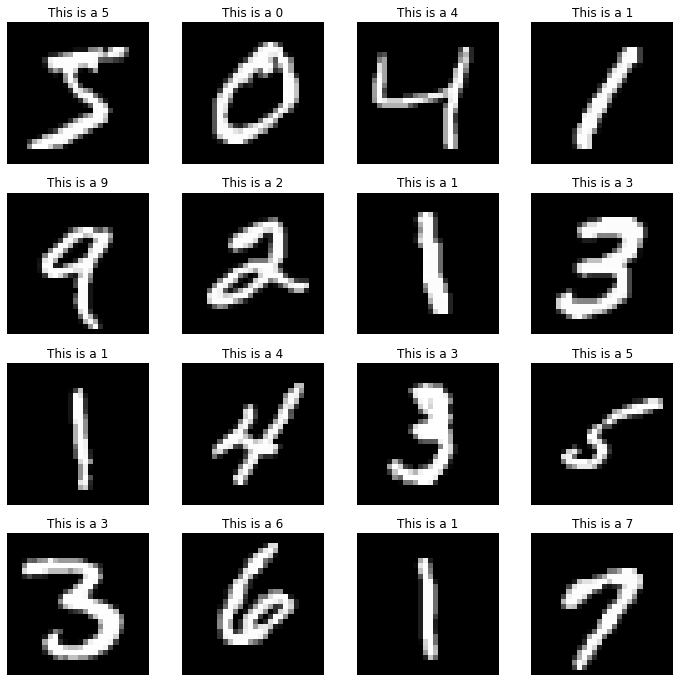

In [5]:
# Number of pictures in the grid
nrows = 4
ncols = 4

# Set up matplotlib fig
longitude_image = 3 # Inches per picture
fig = plt.gcf()
fig.set_size_inches(ncols * longitude_image, nrows * longitude_image)

# Plot some examples
for i in range(nrows*ncols):  
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
    plt.title('This is a ' + str(train_y[i]))

# Plot grid
plt.show()

## Digit recognition

### Shuffle data

In [6]:
# Shuffle train data
permut = np.random.permutation(train_X.shape[0])
train_X = train_X[permut]
train_y = train_y[permut]

# Shuffle test data
permut = np.random.permutation(test_X.shape[0])
test_X = test_X[permut]
test_y = test_y[permut]

### Reshape

In [7]:
# Reshape images to include the channels
train_X = train_X.reshape(train_X.shape + (1,))
test_X = test_X.reshape(test_X.shape + (1,))

# Describe data dimensions
print('Training images dimensions:', train_X.shape)
print('Test images dimensions:', test_X.shape)

Training images dimensions: (60000, 28, 28, 1)
Test images dimensions: (10000, 28, 28, 1)


### Normalize

In [8]:
# Normalize
train_X = train_X / 255.
test_X = test_X / 255.              

### Convert labels to One-hot

In [9]:
# Converte Labels to one hot encoded format
train_y_one_hot = to_categorical(train_y)
test_y_one_hot = to_categorical(test_y)

### Create validation set

In [10]:
# Create validation set
X_train, X_val, y_train, y_val = train_test_split(train_X, 
                                                  train_y_one_hot, 
                                                  test_size=0.05, 
                                                  random_state=1)

In [11]:
# Describe data dimensions
print('Training images dimensions:', X_train.shape)
print('Training labels size:', y_train.shape[0])
print('Validation images dimensions:', X_val.shape)
print('Validation labels size:', y_val.shape[0])
print('Test images dimensions:', test_X.shape)
print('Test labels size:', test_y.shape[0])

Training images dimensions: (57000, 28, 28, 1)
Training labels size: 57000
Validation images dimensions: (3000, 28, 28, 1)
Validation labels size: 3000
Test images dimensions: (10000, 28, 28, 1)
Test labels size: 10000


### Convolutional NN


In [12]:
# Decide whether you want to retrain the model or not
retrain = False # True

if retrain:
    print('The model will be retrained.')
else:
    print('The last saved model saved will be used.')

The last saved model saved will be used.


In [13]:
if retrain:
    
    # Create LeNet-5 architecture
    lenet_5_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Print summary
    lenet_5_model.summary()

In [14]:
if retrain:

    # Compile model
    lenet_5_model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

### Train

In [15]:
if retrain:

    # Set seed for random functions
    tf.random.set_seed(1)

    # Fit the model
    history = lenet_5_model.fit(
        x=X_train,
        y=y_train,
        batch_size=32,
        epochs=30,
        verbose=2,
        validation_data=(X_val, y_val)
    )

In [16]:
if retrain:

    # Save model
    lenet_5_model.save_weights(os.path.join(PATH_MODEL, 'wieghts_lenet_5.h5'))
    lenet_5_model.save(os.path.join(PATH_MODEL, 'digit_recognizer_lenet_5.h5'))

In [17]:
# Load model
lenet_5_model = keras.models.load_model(os.path.join(PATH_MODEL, 'digit_recognizer_lenet_5.h5'))

### Evaluating the model

In [18]:
if retrain:
    
    # Get metrics on training and test data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Save history objects
    joblib.dump(acc, os.path.join(PATH_MODEL, '.acc_lenet_5.h5'))
    joblib.dump(val_acc, os.path.join(PATH_MODEL, 'val_acc_lenet_5.h5'))
    joblib.dump(loss, os.path.join(PATH_MODEL, 'loss_lenet_5.h5'))
    joblib.dump(val_loss, os.path.join(PATH_MODEL, 'val_loss_lenet_5.h5'))
    

In [19]:
# Load history objects
acc = joblib.load(os.path.join(PATH_MODEL, 'acc_lenet_5.h5'))
val_acc = joblib.load(os.path.join(PATH_MODEL, 'val_acc_lenet_5.h5'))
loss = joblib.load(os.path.join(PATH_MODEL, 'loss_lenet_5.h5'))
val_loss = joblib.load(os.path.join(PATH_MODEL, 'val_loss_lenet_5.h5'))


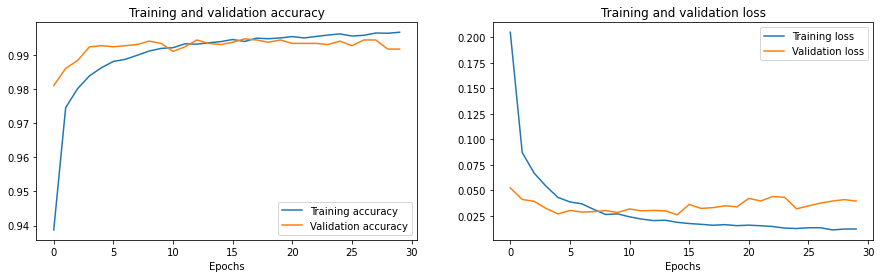

In [33]:
# Get number of epochs
epochs = range(len(acc)) 

# Set subplot
plt.figure(figsize=(15, 4))

# Plot training and validation accuracy per epoch
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend(loc=0)

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend(loc=0)
plt.title('Training and validation loss')
plt.xlabel('Epochs')

# Save figure and show
plt.savefig('app/assets/accuracy.png', dpi=150)
plt.show()

### Test images

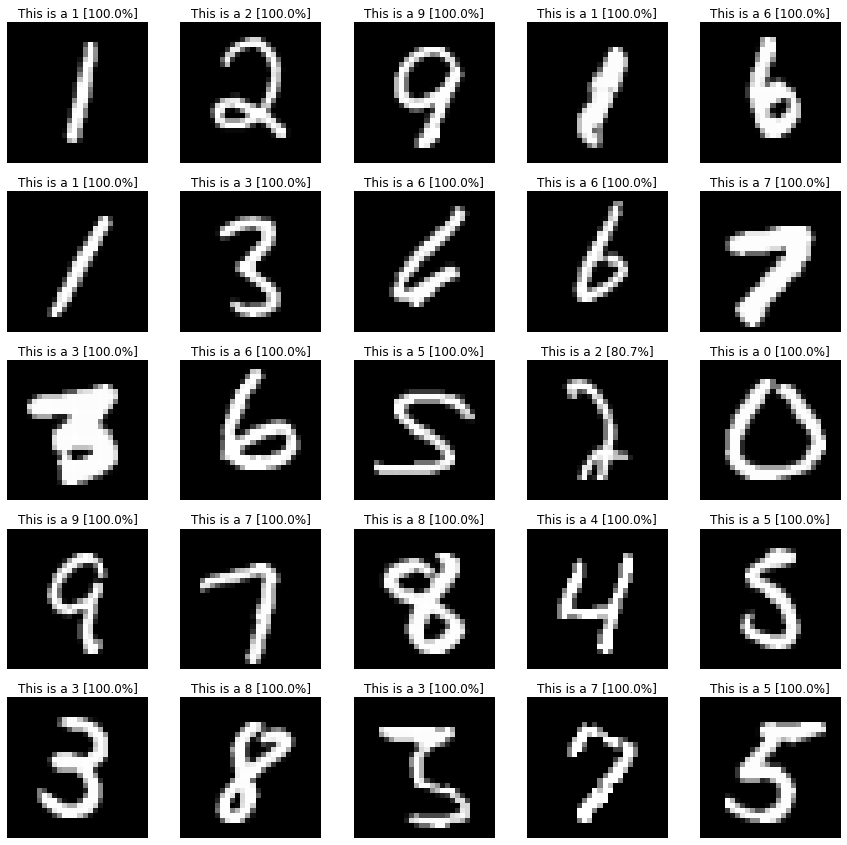

In [21]:
# Number of pictures in the grid
nrows = 5
ncols = 5

# Set up matplotlib fig
longitude_image = 3 # Inches per picture
fig = plt.gcf()
fig.set_size_inches(ncols * longitude_image, nrows * longitude_image)

# Plot some examples
for i in range(nrows*ncols):
    # Pre-process image
    x = test_X[i].reshape((1,) + test_X[i].shape)
    # Predict
    classes = lenet_5_model.predict(x)
    certainty = str(np.max(classes*100).round(1)) + '%'
    prediction = np.argmax(classes, axis=1)
    # Plot image
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(test_X[i], cmap=plt.get_cmap('gray'))
    plt.title('This is a ' + str(prediction[0]) + ' [' + certainty + ']')

# Plot grid
plt.show()


## Use case

In [22]:
# Create canvas to draw digits
use_case_path = os.path.join(PATH_DATA, 'use_case')

def save():
    global i
    image_name = 'image_' + str(i) + '.png'   
    new_image.save(use_case_path + image_name)
    i += 1
    clear()
    
def clear():
    global new_image, draw
    cv.delete("all")
    new_image = PIL.Image.new('RGB', (560, 560), 'black')
    draw = ImageDraw.Draw(new_image)

def activate_paint(e):
    global lastx, lasty
    cv.bind('<B1-Motion>', paint)
    lastx, lasty = e.x, e.y

def paint(e):
    global lastx, lasty
    x, y = e.x, e.y
    cv.create_line((lastx, lasty, x, y), fill='white', width=60, capstyle=ROUND, smooth=True)
    draw.line((lastx, lasty, x, y), fill='white', width=60)
    lastx, lasty = x, y

# Initialize variables
root = Tk()
lastx, lasty = None, None
i = 0

# Create canvas
cv = Canvas(root, width=560, height=560, bg='black')
cv.bind('<1>', activate_paint)
cv.pack(expand=YES, fill=BOTH)

# Create new image
new_image = PIL.Image.new('RGB', (560, 560), 'black')
draw = ImageDraw.Draw(new_image)

# Add buttons
btn_save = Button(text="Save", command=save, fg="green")
btn_save.pack()
btn_clear = Button(text="Clear", command=clear)
btn_clear.pack()

# Add title
root.title("Digit recognition")

# Remove previous images stored
filelist = [f for f in os.listdir(use_case_path) if f.endswith(".png") ]
for f in filelist:
    os.remove(os.path.join(use_case_path, f))

# Run
root.mainloop()

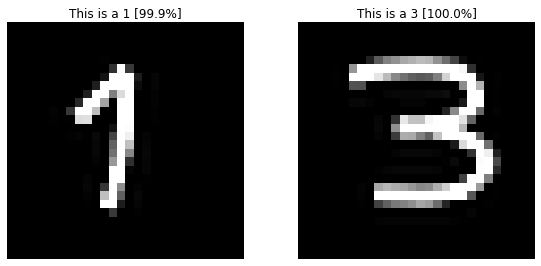

In [23]:
def imageprepare(path_to_image):
    
    """"
    Function to preprocess a raw image and transform it to MNIST style
    """
    
    # Load image and get dimensions
    img = Image.open(path_to_image).convert('L')
    width = float(img.size[0])
    height = float(img.size[1])
    
    # Create new image
    newImage = Image.new('L', (28, 28), 'black')
    nwidth = int(round((20.0 / height * width), 0))  
    img = img.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
    wleft = int(round(((28 - nwidth) / 2), 0)) 
    newImage.paste(img, (wleft, 4))  
    
    # Process image
    img_array = np.array(newImage.getdata()) 
    img_array = tf.reshape(img_array, [28, 28, 1])

    return img_array

# Get names of pictures
use_case_names = os.listdir(use_case_path)

# Number of pictures in the grid
nrows = 4
ncols = 4

# Set up matplotlib fig
longitude_image = 5 # Inches per picture
fig = plt.gcf()
fig.set_size_inches(ncols * longitude_image, nrows * longitude_image)

# Get names of pictures
use_case_names = os.listdir(use_case_path)

# Get path to each image
use_case_pix = [os.path.join(use_case_path, fname) for fname in use_case_names[:nrows*ncols]]

# Plot some examples
for i, img_path in enumerate(use_case_pix):
    
    # Load image
    img = imageprepare(img_path)
    
    # Pre-process image
    input_img = keras.preprocessing.image.img_to_array(img)
    input_img = input_img / 255.
    input_img = input_img.reshape((1,) + input_img.shape)
    
    # Predict
    classes = lenet_5_model.predict(input_img)
    certainty = str(np.max(classes*100).round(1)) + '%'
    prediction = np.argmax(classes, axis=1)
    
    # Plot image
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title('This is a ' + str(prediction[0]) + ' [' + certainty + ']')

# Plot grid
plt.show()